In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.evaluator import Evaluator
from utils.trainer import Trainer
from datetime import datetime


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [18]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 32*32
mogrify_rounds = 5
prediction_window=5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [6]:
import xarray as xr
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...


In [7]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [8]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([32429, 1, 5, 32, 32])
Y :  torch.Size([32429, 1, 5, 32, 32])
-----Val-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 5, 32, 32])
-----Test-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 5, 32, 32])


In [9]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

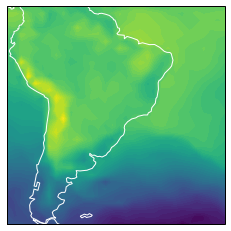

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [12]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [13]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        
    def forward(self,input):
        return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [14]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, input_size, hidden_size
                 ,device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
        self.recurrent = torch.nn.LSTMCell(input_size, hidden_size);
            
            
            
    def forward(self, x, states, dimens):
        batch, channel, time, lat, lon = dimens
        x = x.view(batch*time, channel, lat, lon)
        for conv, bn, mish, dropout in zip(self.conv_layers, self.bn_layers, self.mish_layers, self.dropout_layers):
            x = conv(x)
            x = bn(x)
            x = mish(x)
            x = dropout(x)
        x = x.view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent(x[:,i,:],(h,c))
        return (h, c)

In [16]:
class DecoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, input_size
                 ,device):
        super(DecoderCNN, self).__init__()
        self.device = device
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        
        self.recurrent = torch.nn.LSTMCell(input_size, hidden_size);
        
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
            
            
    def forward(self, states, dimens, window):
        batch, channel, time, lat, lon = dimens
        outputs = torch.zeros(batch, window, lat*lon, device=self.device)
        h = states[0]
        c = states[1]
        inputLSTM = torch.zeros(h.size(), device=self.device)
        for i in range(window):
            h,c = self.recurrent(inputLSTM,(h,c))
            inputLSTM = h
            outputs[:,i,:] = h
        x = outputs.contiguous().view(batch*window, channel, lat, lon)
        for conv, bn, mish, dropout in zip(self.conv_layers, self.bn_layers, self.mish_layers, self.dropout_layers):
            x = conv(x)
            x = bn(x)
            x = mish(x)
            x = dropout(x)
        return x.view(batch, channel, window, lat, lon)

In [17]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height, hidden_size,
                prediction_window, device):
        super(STModel, self).__init__()
        self.device = device
        self.prediction_window = prediction_window
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, input_size=input_width*input_height,
                                 hidden_size = hidden_size, device=device)
        self.decoder = DecoderCNN(layer_size = decoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, input_size=input_width*input_height, device=device)
        
        
    def forward(self, x, states):
        dimens = x.size()
        (h_t, c_t) = self.encoder(x, states, dimens)
        x = self.decoder((h_t,c_t), dimens, self.prediction_window)
        return x
        

In [20]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss


In [21]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], decoder_layer_size = param['decoder_layer_size']
                ,kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], hidden_size = hidden_size, 
                prediction_window = prediction_window, device=device).to(device)
criterion = RMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (1): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (2): CustomConv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
    )
    (mish_layers): ModuleList(
      (0): Mish()
      (1): Mish()
      (2): Mish()
    )
    (bn_layers): ModuleList(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.2, inplace=False)
      (1): Dropout(p=0.2, inplace=False)
      (2): Dropout(p=0.2, inplace=False)
    )
    (recurrent): LSTMCell(1024, 1024)
  )
  (decoder): DecoderCNN(
    (conv_layers):

In [22]:
model_path = os.path.join('../../../models/STTSModel' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, False, model_path, True, 5)


In [23]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 20.253385
Val Avg. Loss: 19.850550
=> Saving a new best


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000292C865AA60>
Traceback (most recent call last):
  File "c:\users\mario\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "c:\users\mario\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "c:\users\mario\anaconda3\envs\pytorch\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "c:\users\mario\anaconda3\envs\pytorch\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


KeyboardInterrupt: 

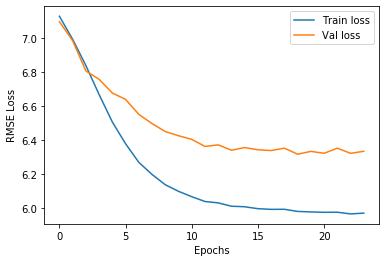

In [22]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [19]:
trainer.path = '../../../models/STTSModel_m04d08-h16m29s13.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
iter_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = trainer.init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        iter_test_loss += loss.detach().item()
test_loss = iter_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

RuntimeError: cuDNN error: CUDNN_STATUS_ALLOC_FAILED

In [34]:
a = model.encoder.conv_layers[0].weight
print(a.shape)
print(a)
c = a.permute(1,0,2,3)
print(c)
print(c.shape)

torch.Size([32, 1, 5, 5])
Parameter containing:
tensor([[[[-4.8743e-02,  5.8953e-02,  1.1359e-02, -9.6594e-02, -4.6702e-02],
          [ 1.2791e-01, -3.5652e-02, -1.1686e-01, -7.0670e-02,  1.0214e-01],
          [-2.8229e-02,  5.3612e-02, -2.8271e-02, -1.5210e-01,  7.8416e-02],
          [-1.2226e-01,  1.3047e-01, -2.3159e-01,  4.7415e-02, -2.3973e-01],
          [-2.0420e-01,  1.8198e-01, -1.0662e-01, -1.4514e-01, -1.2821e-02]]],


        [[[-6.5112e-02,  4.5580e-02, -2.8375e-02, -9.7744e-02,  8.7408e-02],
          [ 9.6152e-02, -2.4841e-01, -4.7911e-03,  1.8294e-01,  1.6325e-01],
          [ 1.6792e-01, -1.5876e-01,  7.3724e-02, -1.1860e-01, -1.2363e-02],
          [-4.5721e-02, -2.9619e-01, -8.9645e-02,  1.0308e-01,  1.4694e-01],
          [ 2.1760e-03,  1.1935e-01, -2.4381e-01,  1.5010e-02,  3.0560e-03]]],


        [[[ 2.2489e-01,  8.6382e-02,  1.3840e-01,  9.3300e-02, -1.1806e-01],
          [-1.3916e-01, -2.0443e-01,  4.4314e-02,  1.1481e-01,  1.1007e-01],
          [ 8.9959e-

In [60]:
len(model.encoder.conv_layers)

3